In [1]:
import pandas as pd 
import numpy as np

class PreProcessing: 
  def load_csv(filename): 
    ''' Load file from Drive as pandas dataframe '''
    df = pd.read_csv(filename, dtype='unicode')
    return df 


  def remove_extra_features(df):  
    ''' Remove unnecessary cols from dataframe '''
    df.drop('SpeciesName', axis=1, inplace=True)
    df.drop('SpeciesID', axis=1, inplace=True)
    df.drop('DNAtype', axis=1, inplace=True)
    df.drop('Ncodons', axis=1, inplace=True)
    return df


  def replace_non_floats(df): 
    ''' 3 locations with the dataframe that should contain floats 
        representing codon frequencies instead have erroneous strings.
        This method replaces said strings with empty spaces. '''
    df['UUU'] = df['UUU'].str.replace(r'non-B hepatitis virus', '')
    df['UUU'] = df['UUU'].str.replace(r'12;I', '')
    df['UUC'] = df['UUC'].str.replace(r'-', '')

    return df 


  def convert_df_to_numeric(df): 
    ''' After filtering out all non-float values from input dataframe, run this 
        method to convert the input data to float type. '''
    target = df['Kingdom']  # store only non-numeric col 

    temp = df.drop('Kingdom', axis=1)  # drop target col from temp df 
    temp = temp.apply(pd.to_numeric)  # convert non-target cols to numeric 
    temp = temp.fillna(-99)  # handle NaNs

    df = pd.concat([target, temp], axis=1)  # merge target, numeric cols
    return df 

# **Step 2: Data exploration**

In [10]:
# load data and preprocess
codons = PreProcessing.load_csv('codon_usage.csv')
codons = PreProcessing.remove_extra_features(codons)
codons = PreProcessing.replace_non_floats(codons)
codons = PreProcessing.convert_df_to_numeric(codons)


## **Preprocessing steps**

I accessed this data from the UC Irvine machine learning repository from a recent study in preprint [accessible here](https://archive.ics.uci.edu/ml/datasets/Codon+usage). They stored this data as a csv which I imported into Google Collab and processed with Python using the numpy and pandas data science packages. The original csv file contained 69 featuures, with the codons composing 64 of these features. The data also contained *Species Name*, *Species ID*, *DNA type*, and *number of codons* features, which I removed because I did not need them for my analysis. 

After removing the extraneous features I observed that pandas set the data type of the remaining 64 codon features to *object* despite the values holding frequencies. Therefore, I converted each of the *object* frequency counts to *floats* for easier numerical analysis. Meanwhile, the output variable had type *string*, I transformed this into type *int* by mapping each kingdom onto a unique integer from [0,10] inclusive. The 11 kingdoms in this dataset include: *arc* (archaea), *bct* (bacteria), *phg* (bacteriophage), *plm* (plasmid), *pln* (plant), *inv* (invertebrate), *vrt* (vertebrate), *mam* (mammal), *rod* (rodent), *pri* (primate), and *vrl* (virus). 


There are 0 missing values in the dataset
There are  13028 samples in the dataset.
There are  65 features in the dataset.


,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
count,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.00000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000
mean,0.009616,0.015841,0.020637,0.014104,0.017820,0.018288,0.019044,0.018450,0.028352,0.025041,0.018294,0.021135,0.017647,0.015175,0.013621,0.016443,0.019935,0.023804,0.019062,0.011699,0.012944,0.01265,0.015694,0.008598,0.011611,0.017217,0.019063,0.018426,0.010530,0.014700,0.013245,0.015392,0.007161,0.009647,0.011086,0.015974,0.019374,0.019109,0.008226,0.018207,0.016175,0.019366,0.015487,0.022531,0.021981,0.007290,0.007595,0.011540,0.012172,0.028504,0.021530,0.008008,0.009659,0.006965,0.005454,0.009929,0.006422,0.024178,0.021164,0.028290,0.021683,0.001645,0.000592,0.006178
std,1.227011,0.867637,0.020709,0.009280,0.010586,0.014572,0.024250,0.016578,0.017507,0.014600,0.016044,0.008163,0.009953,0.010069,0.008315,0.011719,0.009890,0.017244,0.009112,0.013572,0.006765,0.00911,0.009606,0.008960,0.006569,0.010492,0.014768,0.009325,0.007139,0.008950,0.007594,0.009217,0.006120,0.006498,0.006571,0.008210,0.012453,0.013001,0.006774,0.011818,0.007353,0.011300,0.011284,0.015032,0.009510,0.006231,0.006440,0.006843,0.006604,0.017890,0.014577,0.006310,0.010680,0.004787,0.006605,0.008574,0.006387,0.013828,0.013041,0.014342,0.015018,0.001834,0.000907,0.010344
min,-99.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.013910,0.015380,0.005610,0.007107,0.010890,0.007830,0.005307,0.007180,0.016360,0.015130,0.006320,0.015788,0.010520,0.008220,0.006940,0.006900,0.013300,0.010330,0.012990,0.002940,0.008430,0.00571,0.009250,0.002510,0.007107,0.009980,0.008977,0.011967,0.005577,0.008680,0.007820,0.008860,0.002577,0.004280,0.006707,0.010618,0.010050,0.010080,0.003180,0.009650,0.010960,0.012850,0.005848,0.011360,0.015560,0.002660,0.003600,0.007030,0.007187,0.017315,0.010245,0.003150,0.002880,0.003340,0.001220,0.001690,0.001170,0.012380,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410
50%,0.021750,0.021905,0.015260,0.013360,0.016130,0.014560,0.009685,0.012800,0.025475,0.021540,0.014140,0.022000,0.017135,0.013160,0.012670,0.014520,0.018810,0.020245,0.018590,0.007080,0.012410,0.01099,0.014300,0.005670,0.012060,0.015545,0.015390,0.017520,0.009760,0.013730,0.012460,0.014600,0.005600,0.009450,0.010560,0.015680,0.017185,0.016660,0.006550,0.016080,0.015430,0.019040,0.014510,0.019800,0.021170,0.006160,0.006530,0.010620,0.011460,0.025315,0.021090,0.006875,0.005660,0.005990,0.003530,0.009270,0.004545,0.025420,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130
75%,0.

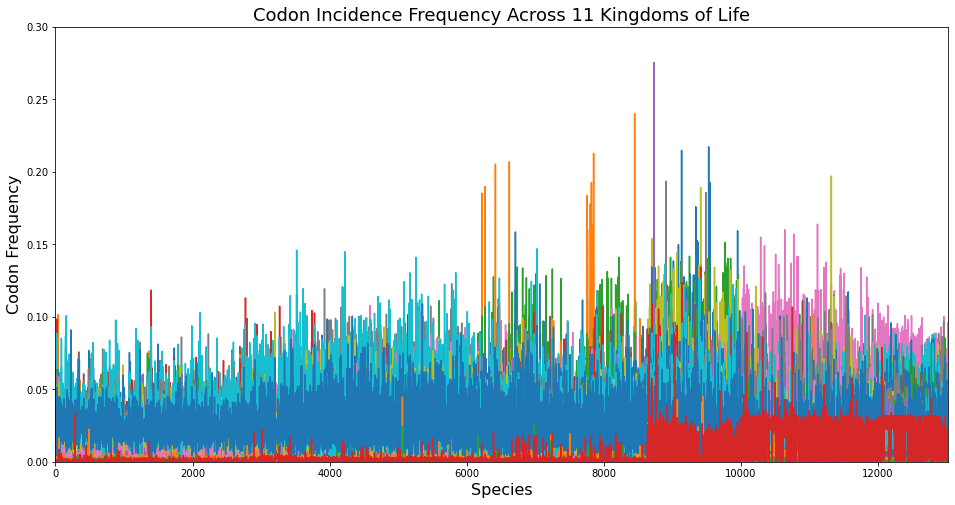

In [11]:
import matplotlib.pyplot as plt

# store number of samples and features 
num_samples = len(codons)
num_features = len(codons.columns)
# check for NaNs in dataframe
nan_count = codons.isnull().sum().sum()
# print preprocessing statistics 
print('There are', nan_count, 'missing values in the dataset')
print('There are ',num_samples,'samples in the dataset.')
print('There are ', num_features, 'features in the dataset.')

# plot codon frequencies 
title = 'Codon Incidence Frequency Across 11 Kingdoms of Life '
codons.plot(figsize=(16,8), legend=False, xlim=(0, len(codons)), ylim=(0,0.3))
plt.xlabel('Species',fontsize=16)
plt.ylabel('Codon Frequency', fontsize=16)
plt.title('Codon Incidence Frequency Across 11 Kingdoms of Life', fontsize=18)
# dataframe statistics
codons.describe()

## **Visualization and statistics**
This dataset presented the frequency of all 64 codons (features) across the genomes for 13,028 organisms across 11 kingdoms of life. 

The figure above presents these frequencies for each organism in the dataset. These frequencies vary species-species with no overt pattern. This lack of easily-identifiable trends made the dataset enticing for applying machine learning paradigms. I intend to apply machine learning algorithms such as decision tree, logistic regression, clustering, and deep learning to determine if A.I. can detect covert patterns within the data to correctly classify an organism's kingdom of life given their codon frequenciess. 

The codon, AGC, occurred in 27.5% of all codons in one organism's genome. No other codon occurred as frequently in any organism's genome. AAA (2.85%), AUU (2.83%), and GAA (2.82%) codons occurred most frequently on average across all species. Despite AGC having the highest sigle-most occurrence, on average it only occurred in 1.11% of all codons across all species. This placed it firmly in the middle of mean codon incidences. 

# **Step 3: Data Processing**

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

class DataTransformations: 
  def create_X_y_sets(df): 
    features = df.drop('Kingdom', axis=1)
    labels = df['Kingdom']
    return features, labels


  def encode_categories(label_df): 
    le = LabelEncoder  # instantiate instance 
    enc_label_df = le.fit_transform(label_df)  # map labels to int
    return enc_label_df 


  def split_datasets(X, y, split_fraction): 
    X_big, X_small, y_big, y_small = train_test_split(X, y, 
                                                      test_size=split_fraction, 
                                                      random_state=42)
    return X_big, X_small, y_big, y_small

  
  def scale_data(df): 
    min_max_scaler = preprocessing.MinMaxScaler()  # instantiate scaler from SKL
    arr = min_max_scaler.fit_transform(df)  # call scaler on input dataframe
    return arr 

In [45]:
# create X, y sets 
X, y = DataTransformations.create_X_y_sets(codons)
# create train, and temp set (will split temp into validation and test sets)
X_train, X_temp, y_train, y_temp = DataTransformations.split_datasets(X, y, 0.2)
# create validation and test set
X_val, X_test, y_val, y_test = DataTransformations.split_datasets(X_temp, 
                                                                  y_temp, 0.5)
# normalize input data sets (train/validation/test)
X_train = DataTransformations.scale_data(X_train)
X_val = DataTransformations.scale_data(X_val)
X_test = DataTransformations.scale_data(X_test)

## **Data Transformations**

The preprocessed dataframe contained one column of labels (the 11 kingdoms) and 64 columns of features (the codons). I split this frame into X and y subframes: the 64 codons and labels. Then I encoded the labels into integers using SKL's LabelEncoder method. This mapped the 11 kingdoms, previously of type *string* onto the integers ranging from [0,11] (**Question 3A**). 

I then created train, validation, and test subsets from the original X and y subframes. Then I split the X and y subsets into a training and temporary subset. The training set, 80% of the original dataframe, will feed into my models for fitting the weights and parameters. This method also output a 'temporary' X and y dataset. These temporary datasets re-inputted into the same method with a 0.5 split fraction produced the validation and test data sets that each contained 10% of the original dataframe (**Question 3B**)*italicized text*. 

# **Step 4: Baseline ML Model**

In [49]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_scaled, y_train.values)
baseline_accuracy = model.score(X_val, y_val.values)

print('Baseline ML accuracy:', baseline_accuracy*100, '%')

Baseline ML accuracy: 38.37298541826554 %


## **Elementary model analysis**

I utilized a multinomial logistic regression model from SK Learn to create a baseline accuracy for my data from which I will attempt to improve in the subsequent iterations. This elementary model achieved 38.4% accuracy on the validation set for classifying the Kingdom of a given organism given its codon frequencies. This is significantly higher than the expected accuracy of ~9-10%, which I expected if the model randomly guessed the Kingdom of each species. Therefore, I anticipate that more careful model selection and (hyper)parameter tuning can result in more accurate classifications. 